# Empirical Application 1 Financial Econometrics

*By Daniel Deutsch, José Lucas Barretto, and Stéphane Roblet*

In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.tsa.stattools as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Motivation

We have chosen these datasets for different reasons. First, we wanted to investigate the price evolution for financial assets when the issuers differ in nature. Thus, we chose to look at the evolution of the price of the New Stock Exchange and government bonds. In addition, we wanted to know if different trends could emerge depending on the nature of the financial asset of the same type of issuer (in this case a company), which is why we were also interested in the evolution of the valuation of AAA corporate bonds in addition to that of shares of companies listed on the NYSE.

# US Governament Bond Yields

## Load the Data

Notice that here we don't apply the log-transform in our data since it is already given in percentage.

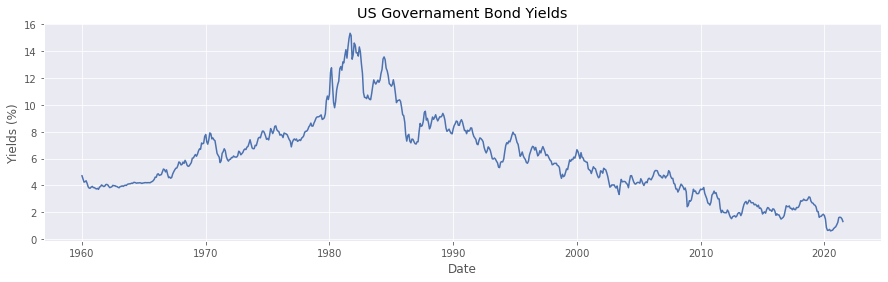

In [3]:
# Loads data and drops non available values
df_govbonds = pd.read_csv("datasets/US_govbonds_yields.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')
df_govbonds.dropna(inplace=True)

# Plots the time series
plt.plot(df_govbonds['date'], df_govbonds['value'])
plt.title("US Governament Bond Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

## Augmented Dickey-Fuller Test

The Augmented Dickey-Fuller test is a unit root test that checks for stationarity. It considers the following hypotesis:

\begin{align*}
    H_0: & \quad \text{there is a unit root (the series contains a stochastic trend and is non-stationary)} \\
    H_1: & \quad \text{there isn't a unit root (the series doesn't contain a stochastic trend and is stationary)}
\end{align*}

Once the Augmented Dickey-Fuller Test is performed and we have obtained our results, we should consider the following to take our conclusions:

- If the p-value is lower than 0.05, than we must reject the null hypotesys (and, consequently, accept the alternativel one).
- If the p-value is slightly above 0.05, then the critical values should be used to judge whether to reject the null hypotesis.

<br>

First, we are going to implement the augmented Dickey-Fuller Test to the most general regression:

\begin{align*}
    \Delta X_t = b_0 + b_1 t + \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{align*}

In this case, the hypotesis can be written as:

\begin{align*}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{align*}

In [4]:
# Obtains the ADF results for the general regression
adf_res = sm.adfuller(
    df_govbonds['value'], 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}")

T-statistic: -2.1596201496468836
P-value: 0.5125920716411859
Used lag: 12


From the results printed above we can conclude that **the null hypotesis shouldn't be rejected**, i.e., there isn't a unit root in the time series (it is non-stationary), since the p-value is way higher than 0.05. One could reach the same conclusion by observing the value of the T-statistic (since it's absolute value is lower than the absolute value of -3.45).

Once we didn't reject the null hypotesis, we should test wether the coefficient $b_1$ is significant or not.

In [5]:
print(adf_res[3].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     10.69
Date:                Sun, 19 Sep 2021   Prob (F-statistic):           2.90e-22
Time:                        21:05:46   Log-Likelihood:                -27.423
No. Observations:                 726   AIC:                             84.85
Df Residuals:                     711   BIC:                             153.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0081      0.004     -2.160      0.0

In the print above, the coefficient $b_1$ is represented by the variable x14 (which can only be seen once you click at "*show more (open the raw output data in a text editor) ...*"). We observe that its T-statistic is -2.141. Since the absolute value of its T-statistic is inferior than the T-statistic of 2.78 at the 5% confidence level, we conclude that **the trend coefficient $b_1$ is not statistically significant**.

Now, since we concluded that $b_1$ isn't statistically significant, we shall perform the ADF test again, but this time considering a restricted regression, as following:

\begin{align*}
    \Delta X_t = b_0 + \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{align*}

Again, our hypotesis can be written as:

\begin{align*}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{align*}

In [5]:
# Obtains the ADF results for the restricted regression
adf_res = sm.adfuller(
    df_govbonds['value'], 
    regression='c',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}")

T-statistic: -1.294841876108271
P-value: 0.6315288451340434
Used lag: 12


Once more, from the results printed above, we can conclude that **the null hypotesis shouldn't be rejected**, i.e., there isn't a unit root in the time series (it is non-stationary), since the p-value is way higher than 0.05. The same conclusion could be reached by observing the value of the T-statistic (since it's absolute value is lower than the absolute value of -2.89).

Once we didn't reject the null hypotesis, we should test wether the coefficient $b_0$ is significant or not.

In [6]:
print(adf_res[3].resols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     11.10
Date:                Sun, 19 Sep 2021   Prob (F-statistic):           6.93e-22
Time:                        16:39:26   Log-Likelihood:                -29.756
No. Observations:                 726   AIC:                             87.51
Df Residuals:                     712   BIC:                             151.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0043      0.003     -1.295      0.1

In the print above, the coefficient $b_0$ is represented by the variable const (which can only be seen once you click at "*show more (open the raw output data in a text editor) ...*"). We observe that its T-statistic is 1.053. Since the absolute value of its T-statistic is inferior than the T-statistic of 2.54 at the 5% confidence level, we conclude that **the drift coefficient $b_0$ is not statistically significant**.

Now, since we concluded that $b_0$ isn't statistically significant, we shall perform the ADF test again, but this time considering an even more restricted regression, as following:

\begin{align*}
    \Delta X_t = \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{align*}

Again, our hypotesis can be written as:

\begin{align*}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{align*}

In [7]:
# Obtains the ADF results for the restricted regression
adf_res = sm.adfuller(
    df_govbonds['value'], 
    regression='nc',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}")

T-statistic: -0.7996081095853742
P-value: 0.3706833546535423
Used lag: 12


Once more, from the results printed above, we can conclude that **the null hypotesis shouldn't be rejected**, i.e., there isn't a unit root in the time series (it is non-stationary), since the p-value is way higher than 0.05. The same conclusion could be reached by observing the value of the T-statistic (since it's absolute value is lower than the absolute value of -1.95).

Once we didn't reject the null hypotesis, we finally conclude that **the series is non-stationary without constant**. We can verify this result by running the Augmented Dickey-Fuller test on the first difference of the series: 

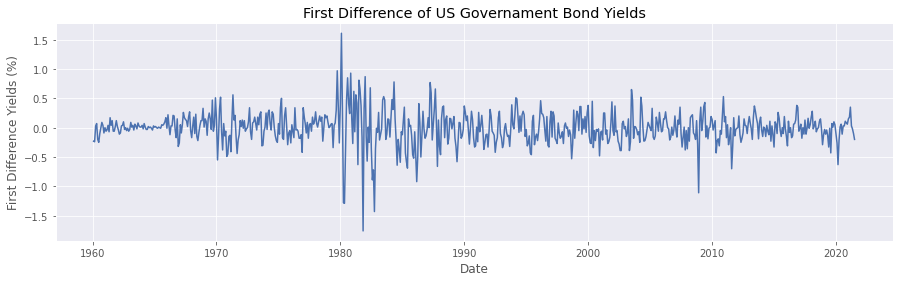

In [8]:
# Obtains the first difference of the time series
df_govbonds['diff'] = df_govbonds['value'].diff()

# Plots the first difference time series
plt.plot(df_govbonds['date'], df_govbonds['diff'])
plt.title("First Difference of US Governament Bond Yields")
plt.xlabel("Date")
plt.ylabel("First Difference Yields (%)")
plt.show()

In [9]:
# Obtains the ADF results for the restricted regression
adf_res = sm.adfuller(
    df_govbonds['diff'].dropna(), 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}")

T-statistic: -7.363656510594449
P-value: 2.0960706199430693e-09
Used lag: 11


From the results printed above, we can conclude that **the null hypotesis should be rejected**, i.e., there is a unit root in the time series (it is stationary), since the p-value is way lower than 0.05. This means that US Governament Bond Yields are I(1).

## Decomposition and Analysis of Drift, Trend, and Seasonality for the First Difference Series

Now, we shall decompose the first difference series into trend, seasonality, and residues (cyclical component). We will assume that the series follow an annual period, and thus, we consider a period of 253 days (average number of trading days per year).

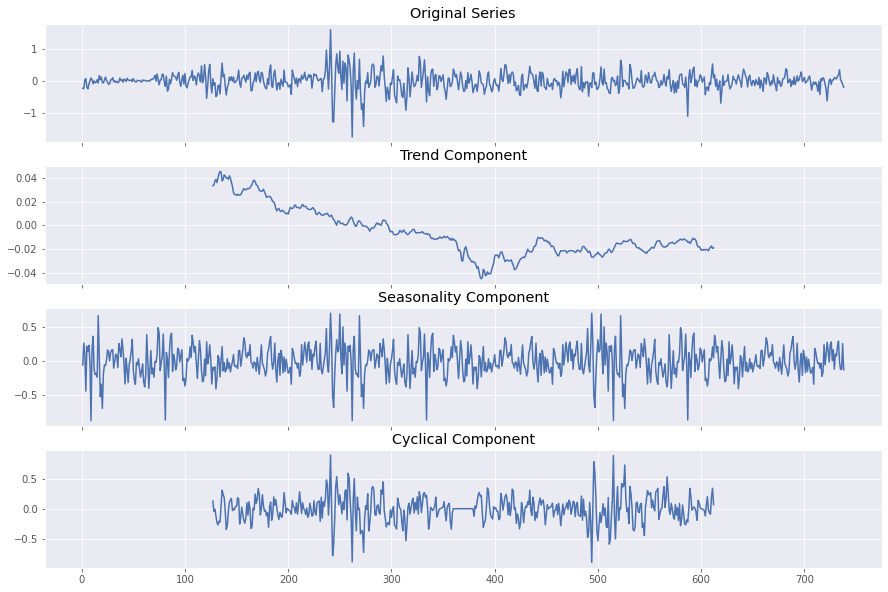

In [10]:
# Decomposes the time series
decomposition = seasonal_decompose(df_govbonds['diff'].dropna(), model='additive', period=253)

# Plot
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 10))
df_govbonds['diff'].plot(ax=axs[0])
decomposition.trend.plot(ax=axs[1])
decomposition.seasonal.plot(ax=axs[2])
decomposition.resid.plot(ax=axs[3])
axs[0].set_title("Original Series")
axs[1].set_title("Trend Component")
axs[2].set_title("Seasonality Component")
axs[3].set_title("Cyclical Component")
plt.show()

### Deterministic Trend

In [11]:
model = OLS(df_govbonds['diff'].dropna(), decomposition.trend, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.728
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                       0.189
Time:                        16:39:27   Log-Likelihood:                         -130.86
No. Observations:                 486   AIC:                                      263.7
Df Residuals:                     485   BIC:                                      267.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

From the print above we can see that the trend component isn't statistically significant at the level 5%. This result indicates that the series doesn't have a deterministic trend when considering an annual period.

### Seasonality

In [12]:
model = OLS(df_govbonds['diff'].dropna(), decomposition.seasonal, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.317
Model:                            OLS   Adj. R-squared (uncentered):              0.316
Method:                 Least Squares   F-statistic:                              341.6
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                    5.79e-63
Time:                        16:39:27   Log-Likelihood:                          46.544
No. Observations:                 738   AIC:                                     -91.09
Df Residuals:                     737   BIC:                                     -86.48
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

From the print above we can see that the seasonal component is statistically significant at the level 5%. This result indicates that the series has seasonality when considering an annual period.

We can also verify this by using dummy variables for each month and verifying their statistical significance.

In [13]:
# Creates dummy vars columns for week of the year
df_govbonds['period'] = df_govbonds['date'].dt.weekofyear

# Create a column for each dummy var
for period in df_govbonds['period'].unique():
    df_govbonds[f'is_{period}'] = 1*(df_govbonds['period'] == period)

# Include all dummy vars except one
X = df_govbonds[[f'is_{period}' for period in sorted(df_govbonds['period'].unique())[:-1]]]

# Run regression
model = OLS(df_govbonds['diff'], X, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):             -0.009
Method:                 Least Squares   F-statistic:                             0.7028
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                       0.846
Time:                        16:39:27   Log-Likelihood:                         -85.748
No. Observations:                 738   AIC:                                      217.5
Df Residuals:                     715   BIC:                                      323.4
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The results indicate that some weeks of the year have statistically significant impacts on the value of the first difference series. This supports the previous finding that the series has a significant seasonal component.

## Stationary ARMA Model

The goal here is to estimate the cyclical component through a stationary ARMA model. Firstly, we can plot the Autocorrelation and the Partial Autocorrelation of the time series to have an idea of the parameters of the model.

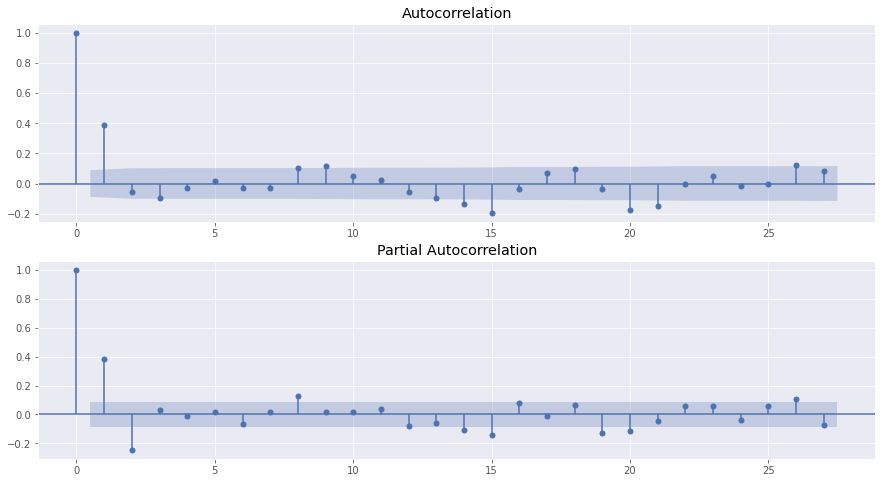

In [14]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(decomposition.resid.dropna(), ax=axs[0])
plot_pacf(decomposition.resid.dropna(), ax=axs[1])
plt.show()

To obtain the best parameters for the ARMA model we run a cross-validation using the AIC score (select the model with the lowest AIC).

In [15]:
best_model = None
for p, q in itertools.product(range(10), range(10)):

    print(f"\rCurrent {p=}, {q=}", end="")

    model = ARIMA(decomposition.resid.dropna(), order=(p, 0, q))
    model_fit = model.fit()

    if p == 0 and q == 0:
        best_model = model_fit

    if model_fit.aic < best_model.aic:
        best_model = model_fit

print(best_model.summary())

Current p=9, q=9                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  486
Model:                 ARIMA(4, 0, 9)   Log Likelihood                 125.189
Date:                Sun, 19 Sep 2021   AIC                           -220.378
Time:                        16:44:15   BIC                           -157.585
Sample:                             0   HQIC                          -195.708
                                - 486                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0072      0.012     -0.587      0.557      -0.031       0.017
ar.L1          0.0366      0.094      0.388      0.698      -0.148       0.221
ar.L2          0.3762      0.078    

# Moody's AAA Corporate Bond Yields

## Load the Data

Notice that here we don't apply the log-transform in our data since it is already given in percentage.

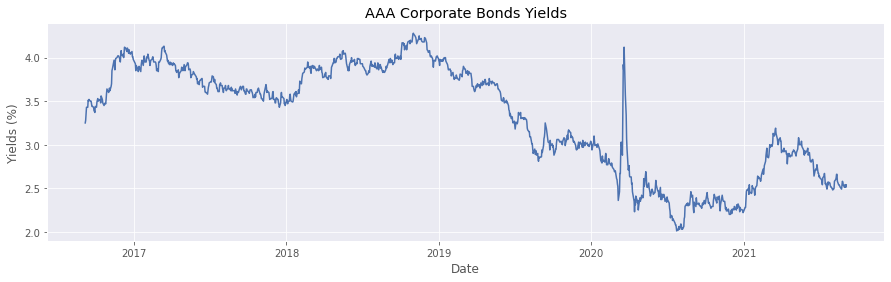

In [16]:
# Loads data and drops non available values
df_aaa = pd.read_csv("datasets/AAA_corpbonds_yields.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')
df_aaa.dropna(inplace=True)

# Plots the time series
plt.plot(df_aaa['date'], df_aaa['value'])
plt.title("AAA Corporate Bonds Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

## Augmented Dickey-Fuller Test

First, we are going to implement the augmented Dickey-Fuller Test to the most general regression:

\begin{align*}
    \Delta X_t = b_0 + b_1 t + \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{align*}

In this case, the hypotesis can be written as:

\begin{align*}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{align*}

In [17]:
# Obtains the ADF results for the general regression
adf_res = sm.adfuller(
    df_aaa['value'], 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -2.658179551223335
P-value: 0.25385353029949714
Used lag: 9

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     5.337
Date:                Sun, 19 Sep 2021   Prob (F-statistic):           2.63e-08
Time:                        16:44:16   Log-Likelihood:                 1955.7
No. Observations:                1241   AIC:                            -3887.
Df Residuals:                    1229   BIC:                            -3826.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

We verify that p-value for the ADF is not low enough, which means that we do not reject $H_0: \rho = 0$.

Then, we verify if the coefficient of the trend is statistically significant. Since the t-stat for x11 = -2.539, we conclude that the coef. of the trend is not statistically significant compared to the critical value of 2.78 at the 5% cofidence level.

The next step is to run the test again without the trend term.

In [18]:
# Obtains the ADF results for the restricted regression
adf_res = sm.adfuller(
    df_aaa['value'], 
    regression='c',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -1.033952299163935
P-value: 0.7406804882311689
Used lag: 9

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     5.203
Date:                Sun, 19 Sep 2021   Prob (F-statistic):           1.66e-07
Time:                        16:44:16   Log-Likelihood:                 1952.5
No. Observations:                1241   AIC:                            -3883.
Df Residuals:                    1230   BIC:                            -3827.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

We do not reject the non-stationarity hypothesis, because the p-value is 0.713.

Then, we check that constant term is NOT statistically significant, because its t-value is not high enough.

The next step is to run a restricted regression (no constand and no trend.)

In [19]:
# Obtains the ADF results for the restricted regression
adf_res = sm.adfuller(
    df_aaa['value'], 
    regression='nc',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -0.7469882196814753
P-value: 0.39281257611444154
Used lag: 9

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.040
Model:                            OLS   Adj. R-squared (uncentered):              0.032
Method:                 Least Squares   F-statistic:                              5.149
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                    2.06e-07
Time:                        16:44:16   Log-Likelihood:                          1952.1
No. Observations:                1241   AIC:                                     -3884.
Df Residuals:                    1231   BIC:                                     -3833.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t  

Since we cannot reject the non-stationarity hypothesis, the ADF test suggests that the series is non-stationary without constant. This means that the series has a unit root (stochastic trend), but no drift. We can check this result by running the ADF test on the first difference of the series.

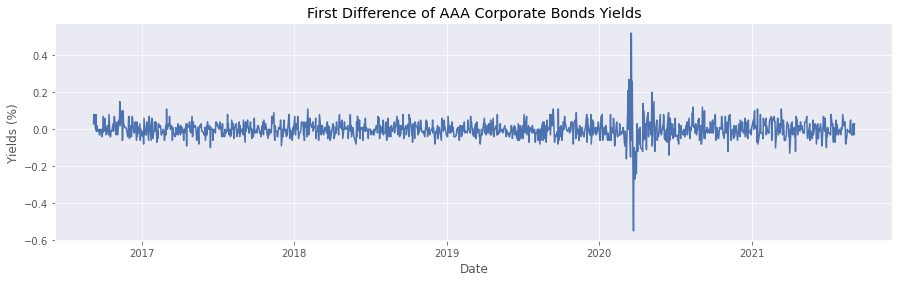

In [20]:
df_aaa['diff'] = df_aaa['value'].diff()

# Plot
plt.plot(df_aaa['date'], df_aaa['diff'])
plt.title("First Difference of AAA Corporate Bonds Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

In [21]:
adf_res = sm.adfuller(
    df_aaa['diff'].dropna(), 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -13.713251329274184
P-value: 2.0647792264106046e-21
Used lag: 8

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     131.1
Date:                Sun, 19 Sep 2021   Prob (F-statistic):          6.81e-186
Time:                        16:44:16   Log-Likelihood:                 1952.2
No. Observations:                1241   AIC:                            -3882.
Df Residuals:                    1230   BIC:                            -3826.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

By running the ADF test on the first difference series, we obtain the result that the non-stationarity hypothesis is rejected, which means that AAA Corporate Bond Yields are I(1). We can also see that both the constant and trend coefficients are not significant, suggesting that the first difference series does not have drift or trend.

## Decomposition and Analysis of Drift, Trend, and Seasonality for the First Difference Series

Now, we shall decompose the first difference series into trend, seasonality, and residues (cyclical component). We will assume that the series follow an annual period, and thus, we consider a period of 253 days (average number of trading days per year).

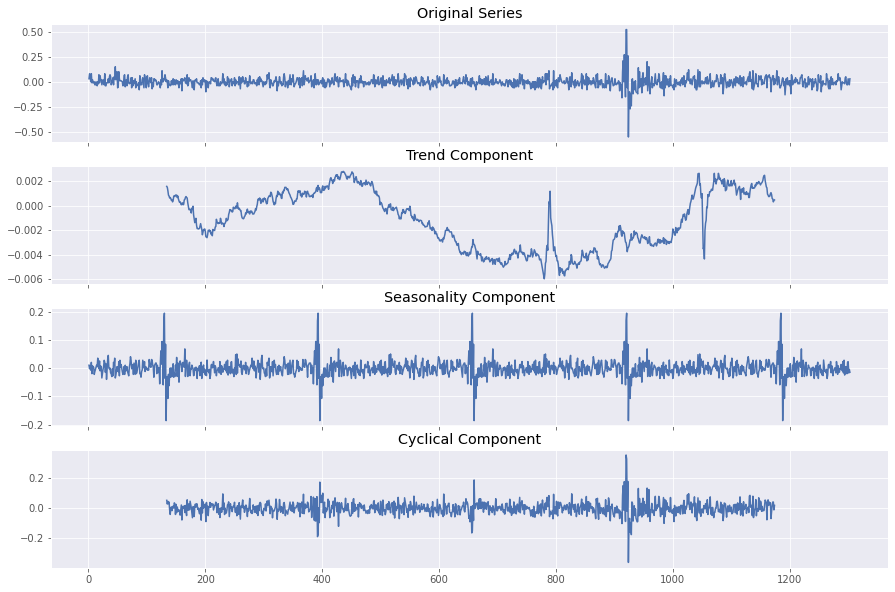

In [22]:
# Decomposes the time series
decomposition = seasonal_decompose(df_aaa['diff'].dropna(), model='additive', period=253)

# Plot
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 10))
df_aaa['diff'].plot(ax=axs[0])
decomposition.trend.plot(ax=axs[1])
decomposition.seasonal.plot(ax=axs[2])
decomposition.resid.plot(ax=axs[3])
axs[0].set_title("Original Series")
axs[1].set_title("Trend Component")
axs[2].set_title("Seasonality Component")
axs[3].set_title("Cyclical Component")
plt.show()

### Deterministic Trend

In [23]:
model = OLS(df_aaa['diff'].dropna(), decomposition.trend, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              2.915
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                      0.0881
Time:                        16:44:17   Log-Likelihood:                          1511.8
No. Observations:                 998   AIC:                                     -3022.
Df Residuals:                     997   BIC:                                     -3017.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We can see that the trend component is not statistical significant at the 5% level, which confirms our previous findings. Therefore, these results indicate that the series don't have a deterministic trend when considering an annual period.

### Seasonality

In [24]:
model = OLS(df_aaa['diff'].dropna(), decomposition.seasonal, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.173
Model:                            OLS   Adj. R-squared (uncentered):              0.172
Method:                 Least Squares   F-statistic:                              260.8
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                    2.00e-53
Time:                        16:44:17   Log-Likelihood:                          2060.0
No. Observations:                1250   AIC:                                     -4118.
Df Residuals:                    1249   BIC:                                     -4113.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We can see that the seasonal component is statistically significant, when considering a period equivalent to the trading year, indicating that there's seasonality in the series. We can also verify this by using dummy variables for each month and verifying their statistical significance.

In [25]:
# create dummy vars columns for week of the year
df_aaa['period'] = df_aaa['date'].dt.weekofyear

# create a column for each dummy var
for period in df_aaa['period'].unique():
    df_aaa[f'is_{period}'] = 1*(df_aaa['period'] == period)

# include all dummy vars except one
X = df_aaa[[f'is_{period}' for period in sorted(df_aaa['period'].unique())[:-1]]]

# run regression
model = OLS(df_aaa['diff'], X, missing='drop')
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.065
Model:                            OLS   Adj. R-squared (uncentered):              0.024
Method:                 Least Squares   F-statistic:                              1.599
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                     0.00493
Time:                        16:44:17   Log-Likelihood:                          1983.4
No. Observations:                1250   AIC:                                     -3863.
Df Residuals:                    1198   BIC:                                     -3596.
Df Model:                          52                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The results indicate that some weeks of the year have statistically significant impacts on the value of the first difference series. This supports the previous finding that the series has a significant seasonal component.

## Stationary ARMA Model

The goal here is to estimate the cyclical component through a stationary ARMA model. First, let's estimate the parameters q and p through the autocorrelation and partial autocorrelation of the series.

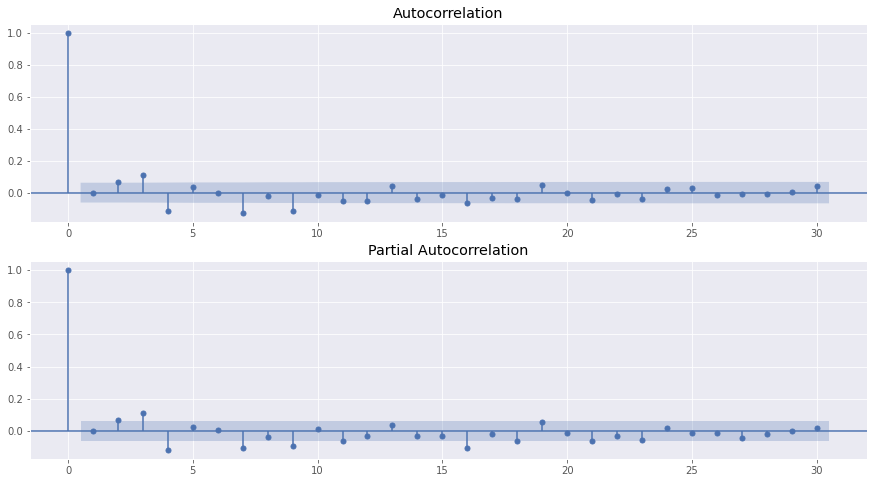

In [26]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(decomposition.resid.dropna(), ax=axs[0])
plot_pacf(decomposition.resid.dropna(), ax=axs[1])
plt.show()

From the autocorrelation plot we can estimate that values are close enough to zero when $q>9$, and from the partial autocorrelation plot, we can estimate the same when $p>7$. Now, we can fit the model and verify the results.

In [27]:
arma_model = ARIMA(decomposition.resid.dropna(), order=(9, 0, 7))
print(arma_model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  998
Model:                 ARIMA(9, 0, 7)   Log Likelihood                1716.102
Date:                Sun, 19 Sep 2021   AIC                          -3396.204
Time:                        16:44:28   BIC                          -3307.901
Sample:                             0   HQIC                         -3362.640
                                - 998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.286      0.775      -0.001       0.002
ar.L1          0.0299      0.365      0.082      0.935      -0.686       0.745
ar.L2          0.1119      0.262      0.427      0.6

# NYSE Stock Yields

## Load the Data

Notice that here we don't apply the log-transform in our data since it is already given in percentage.

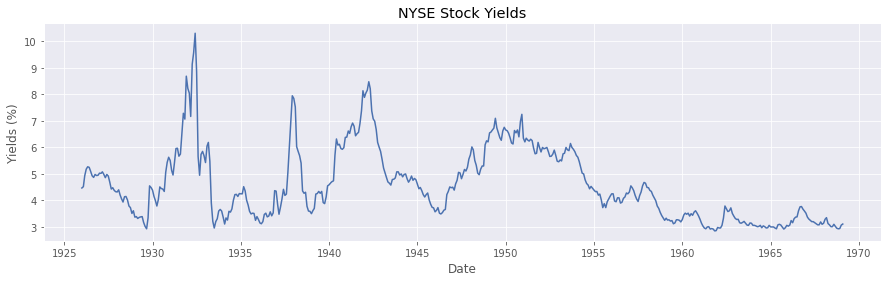

In [28]:
# Loads data and drops non available values
df_nyse = pd.read_csv("./datasets/NYSE_stock_yields.csv", names=['date', 'value'], parse_dates=['date'], skiprows=[0], na_values='.')
df_nyse.dropna(inplace=True)

# Plots the time series
plt.plot(df_nyse['date'], df_nyse['value'])
plt.title("NYSE Stock Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

First, we are going to implement the augmented Dickey-Fuller Test to the most general regression:

\begin{align*}
    \Delta X_t = b_0 + b_1 t + \rho X_{t-1} + \sum^{p-1}_{j=1} \varphi_j \Delta_{t-j} + \varepsilon_t 
\end{align*}

In this case, the hypotesis can be written as:

\begin{align*}
    H_0: & \quad \rho = 0 \\
    H_1: & \quad \rho < 0
\end{align*}

In [29]:
# Obtains the ADF results for the general regression
adf_res = sm.adfuller(
    df_nyse['value'], 
    regression='ct',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -3.4096114441815564
P-value: 0.050116958198374056
Used lag: 4

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     14.88
Date:                Sun, 19 Sep 2021   Prob (F-statistic):           1.06e-15
Time:                        16:44:29   Log-Likelihood:                -110.74
No. Observations:                 513   AIC:                             235.5
Df Residuals:                     506   BIC:                             265.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

We can see that the t-statistic is not statistically significant at a 1% risk level so we can not reject the null hypothesis. b1 (here x6) is not statistically significant.

Thus, we perform the restricted regression without the trend term.

In [30]:
# Obtains the ADF results
adf_res = sm.adfuller(
    df_nyse['value'], 
    regression='c',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -3.0879577428483445
P-value: 0.02745730031042599
Used lag: 4

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     17.40
Date:                Sun, 19 Sep 2021   Prob (F-statistic):           6.53e-16
Time:                        16:44:29   Log-Likelihood:                -111.81
No. Observations:                 513   AIC:                             235.6
Df Residuals:                     507   BIC:                             261.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

We can see that the t-statistic is not statistically significant at a 1% risk level so we can not reject the null hypothesis.

b0 (here constant) is not statistically significant at a 1% risk level

Thus, we perform the restricted regression without the trend term and without the constant

In [31]:
# Obtains the ADF results
adf_res = sm.adfuller(
    df_nyse['value'], 
    regression='nc',
    maxlag=12, 
    autolag='AIC', 
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -1.0848432040960392
P-value: 0.2513731607012235
Used lag: 4

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.132
Model:                            OLS   Adj. R-squared (uncentered):              0.124
Method:                 Least Squares   F-statistic:                              15.51
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                    3.27e-14
Time:                        16:44:30   Log-Likelihood:                         -116.03
No. Observations:                 513   AIC:                                      242.1
Df Residuals:                     508   BIC:                                      263.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t   

The t-value is not statistically significant

We conclude that the series is not stationnary without a drift. 

We will now investigate the first difference time series in order to see if the series is I(1).

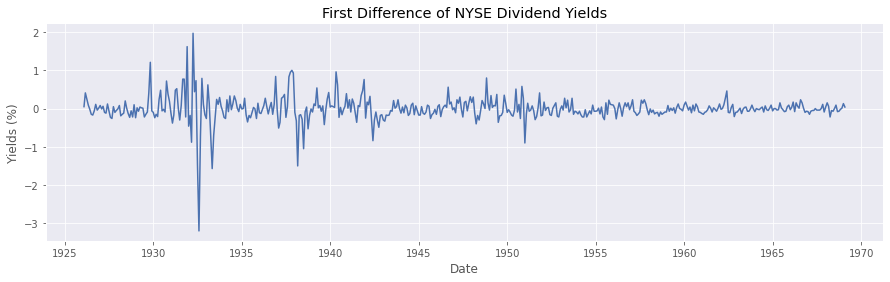

In [32]:
df_nyse['diff'] = df_nyse['value'].diff()

# Plot
plt.plot(df_nyse['date'], df_nyse['diff'])
plt.title("First Difference of NYSE Dividend Yields")
plt.xlabel("Date")
plt.ylabel("Yields (%)")
plt.show()

In [33]:
adf_res = sm.adfuller(
    df_nyse['diff'].dropna(),
    regression='ct',
    maxlag=12,
    autolag='AIC',
    regresults=True
)

# Show test results
print(f"T-statistic: {adf_res[0]}")
print(f"P-value: {adf_res[1]}")
print(f"Used lag: {adf_res[3].usedlag}\n")
print(adf_res[3].resols.summary())

T-statistic: -6.9019835918490875
P-value: 2.3517361165049426e-08
Used lag: 12

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     25.15
Date:                Sun, 19 Sep 2021   Prob (F-statistic):           4.69e-49
Time:                        16:44:30   Log-Likelihood:                -108.70
No. Observations:                 504   AIC:                             247.4
Df Residuals:                     489   BIC:                             310.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

We can see that the t-value is statistically significant.

The b0 (constant) and b1 (trend term) are not statiscally significant, whichconfirms our previous findings.

We conclude that the time series is I(1) with no drift.

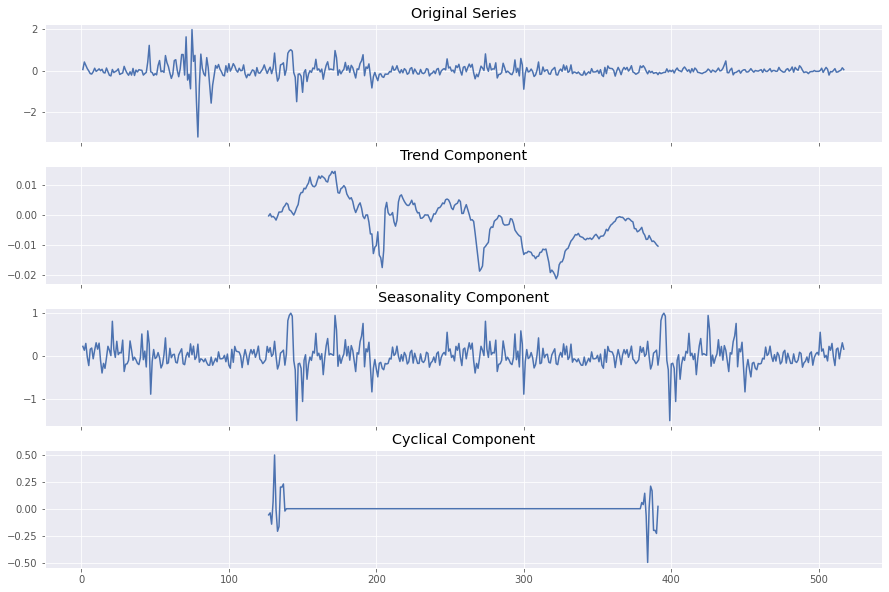

In [34]:
# Decomposes the time series
decomposition = seasonal_decompose(df_nyse['diff'].dropna(), model='additive', period=253)

# Plot
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 10))
df_nyse['diff'].plot(ax=axs[0])
decomposition.trend.plot(ax=axs[1])
decomposition.seasonal.plot(ax=axs[2])
decomposition.resid.plot(ax=axs[3])
axs[0].set_title("Original Series")
axs[1].set_title("Trend Component")
axs[2].set_title("Seasonality Component")
axs[3].set_title("Cyclical Component")
plt.show()

### Deterministic Trend

In [35]:
model = OLS(df_nyse['diff'].dropna(), decomposition.trend, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.019
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              5.098
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                      0.0248
Time:                        16:44:32   Log-Likelihood:                         -36.898
No. Observations:                 265   AIC:                                      75.80
Df Residuals:                     264   BIC:                                      79.38
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We find that b1 is not statiscally significant

### Seasonality

In [36]:
model = OLS(df_nyse['diff'].dropna(), decomposition.seasonal, missing='drop')
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                   diff   R-squared (uncentered):                   0.174
Model:                            OLS   Adj. R-squared (uncentered):              0.172
Method:                 Least Squares   F-statistic:                              108.6
Date:                Sun, 19 Sep 2021   Prob (F-statistic):                    3.26e-23
Time:                        16:44:32   Log-Likelihood:                         -103.40
No. Observations:                 517   AIC:                                      208.8
Df Residuals:                     516   BIC:                                      213.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The seasonal coefficient is statiscally significant. The time series has a seasonal component.

## Stationary ARMA Model

The goal here is to estimate the cyclical component through a stationary ARMA model. First, let's estimate the parameters q and p through the autocorrelation and partial autocorrelation of the series.

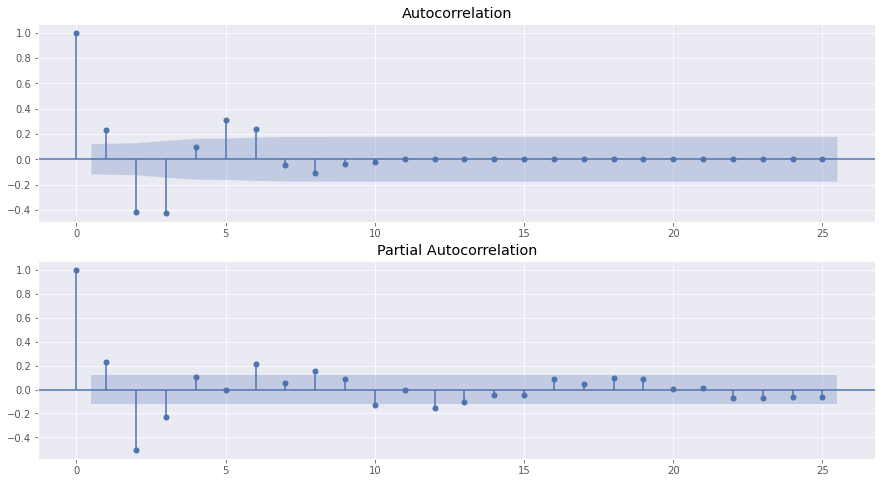

In [37]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(decomposition.resid.dropna(), ax=axs[0])
plot_pacf(decomposition.resid.dropna(), ax=axs[1])
plt.show()

Graphically we can estimate $q>6$.

In [39]:
arma_model = ARIMA(decomposition.resid.dropna(), order=(6, 0, 12))
print(arma_model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  265
Model:                ARIMA(6, 0, 12)   Log Likelihood                 455.402
Date:                Sun, 19 Sep 2021   AIC                           -870.804
Time:                        16:45:48   BIC                           -799.210
Sample:                             0   HQIC                          -842.039
                                - 265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.004      0.781      0.435      -0.005       0.012
ar.L1          0.0639      2.432      0.026      0.979      -4.702       4.830
ar.L2         -0.2614      2.058     -0.127      0.8